In [1]:
from shapely import Point, Polygon, LineString
from shapely.plotting import plot_polygon, _path_from_polygon
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.quiver import Quiver

from matplotlib import animation
import numpy as np

In [ ]:
class Robot:
    def __init__(
        self,
        x: int | float,
        y: int | float,
        theta: float,
        radius: int | float,
        max_distance: int | float,
    ) -> None:
        self.theta = theta
        self.center_pos = [x, y]
        self.radius = radius
        self.max_distance = max_distance

    def get_shape(self) -> Polygon:
        x, y = self.center_pos
        return Point(x, y).buffer(self.radius)

    def get_direction(self) -> tuple[float, float, float, float]:
        x, y = self.center_pos
        dx = self.radius * np.cos(self.theta)
        dy = self.radius * np.sin(self.theta)
        return x + dx, y + dy, 4 * dx, 4 * dy

    def visualize(self, ax=None, alpha=1, color="blue") -> list[PathPatch, Quiver]:
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_aspect("equal")

        polygon = plot_polygon(
            self.get_shape(),
            ax=ax,
            color=color,
            add_points=False,
            alpha=alpha,
            edgecolor="black",
            linewidth=0,
        )

        arrow = ax.quiver(
            *self.get_direction(),
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.003,
            color=color,
            alpha=alpha,
        )

        return [polygon, arrow]

    def measure_distance(self, world: Polygon) -> float:
        robot_shape = self.get_shape()
        ray = LineString(
            [
                self.center_pos,
                (
                    self.center_pos[0] + self.max_distance * np.cos(self.theta),
                    self.center_pos[1] + self.max_distance * np.sin(self.theta),
                ),
            ]
        )
        intersection = ray.intersection(world.boundary, grid_size=0.1)

        if intersection.is_empty:
            distance = self.max_distance
        else:
            # if multiple intersections
            # after test, shapely returns the closest one
            distance = robot_shape.distance(intersection)

        return distance

    def move(self, distance: int | float) -> None:
        dx = distance * np.cos(self.theta)
        dy = distance * np.sin(self.theta)
        self.center_pos[0] += dx
        self.center_pos[1] += dy

    def update_artist(self, artists: list) -> None:
        polygon, arrow = artists
        polygon: PathPatch
        polygon.set_path(_path_from_polygon(self.get_shape()))
        x, y, dx, dy = self.get_direction()
        arrow.set_offsets([x, y])
        arrow.set_UVC(dx, dy)


class SampleParticle(Robot):
    def __init__(
        self,
        x: int | float,
        y: int | float,
        theta: float,
        radius: int | float,
        weight: float = 1,
    ) -> None:
        super().__init__(x, y, theta, radius)
        self.weight = weight

    def update_weight(self, factor: float) -> None:
        self.weight = factor

    def visualize(self, ax=None, color="blue"):
        return super().visualize(ax, self.weight, color)

    def update_artist(self, artists: list) -> None:
        polygon, arrow = artists
        polygon: PathPatch
        polygon.set_path(_path_from_polygon(self.get_shape()))
        polygon.set_alpha(self.weight)
        x, y, dx, dy = self.get_direction()
        arrow.set_offsets([x, y])
        arrow.set_UVC(dx, dy)
        arrow.set_alpha(self.weight)


class ParticleGroup:
    def __init__(
        self,
        positions: np.ndarray,
        thetas: np.ndarray,
        weights: np.ndarray,
        radius: int | float,
        max_distance: int | float,
    ) -> None:
        self.num_particles = len(positions)
        self.positions = positions
        self.thetas = thetas
        self.weights = weights
        self.radius = radius
        self.max_distance = max_distance

    def measure_distance(self, world: Polygon) -> np.ndarray:
        distances = np.zeros(self.num_particles)
        for i, (x, y, theta) in enumerate(self.positions):
            robot = Robot(
                x, y, theta, radius=self.radius, max_distance=self.max_distance
            )
            distances[i] = robot.measure_distance(world)

        return distances

    def update_weights(self, weights: np.ndarray) -> None:
        self.weights = weights

    def resample(
        self,
        lvr_idx: np.ndarray,
        random_positions: np.ndarray,
        random_thetas: np.ndarray,
    ) -> None:
        self.positions = np.concatenate(
            [
                self.positions[lvr_idx],
                random_positions,
            ]
        )
        self.thetas = np.concatenate(
            [
                self.thetas[lvr_idx],
                random_thetas,
            ]
        )
        self.weights = np.ones(len(self.positions)) / len(self.positions)


In [ ]:
class Map:
    def __init__(self, boundary: list[tuple], obstacles: list[list[tuple]]) -> None:
        self.world = Polygon(boundary, holes=obstacles)

    def visualize(self, ax=None) -> None:
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_aspect("equal")
        plot_polygon(self.world, ax=ax, add_points=False, color="gray", alpha=0.4)

    def sample_points(self, n: int, robot_radius: int | float) -> list[tuple]:
        """
        Sample n points in the world, avoiding obstacles.

        Returns:
            list[tuple]: List of (x, y) coordinates of the sampled points.
        """
        min_x, min_y, max_x, max_y = self.world.bounds
        points = []
        while len(points) < n:
            x = np.random.uniform(min_x, max_x)
            y = np.random.uniform(min_y, max_y)
            point = Point(x, y).buffer(robot_radius)
            if self.world.contains(point):
                points.append((x, y))
        return points

In [4]:
map = Map(
    boundary=[
        (0, 0),
        (50, 0),
        (50, 50),
        (150, 50),
        (150, 0),
        (200, 0),
        (200, 50),
        (300, 50),
        (300, 100),
        (250, 100),
        (250, 200),
        (150, 250),
        (100, 300),
        (50, 200),
        (50, 150),
        (0, 50),
    ],
    obstacles=[
        [
            (150, 100),
            (100, 150),
            (150, 200),
            (200, 150),
        ]
    ],
)

In [5]:
particle = Robot(x=100, y=100, theta=0.5, radius=3)

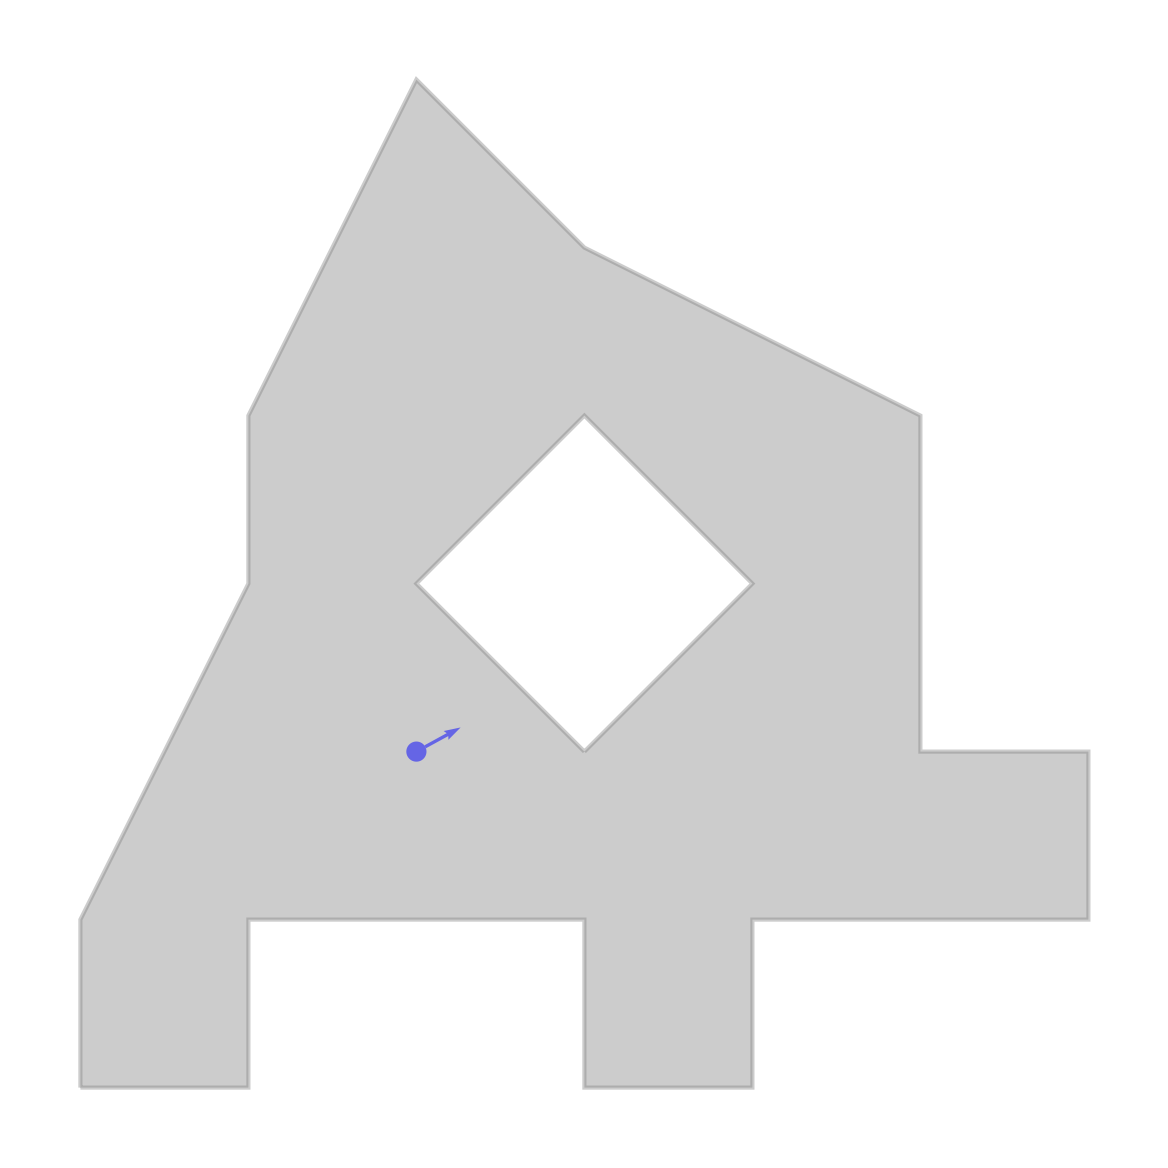

In [6]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")
map.visualize(ax=ax)
# plot_line(ray, color='red')
particle.visualize(ax=ax, alpha=0.5)

In [7]:
sample_particles = []
distances = []
for x, y in map.sample_points(n=100, robot_radius=3):
    theta = np.random.uniform(0, 2 * np.pi)
    particle = Robot(x=x, y=y, theta=theta, radius=3)
    sample_particles.append(particle)
    distances.append(particle.measure_distance(map.world, max_distance=100))

real_robot = Robot(x=100, y=100, theta=0.5, radius=3)

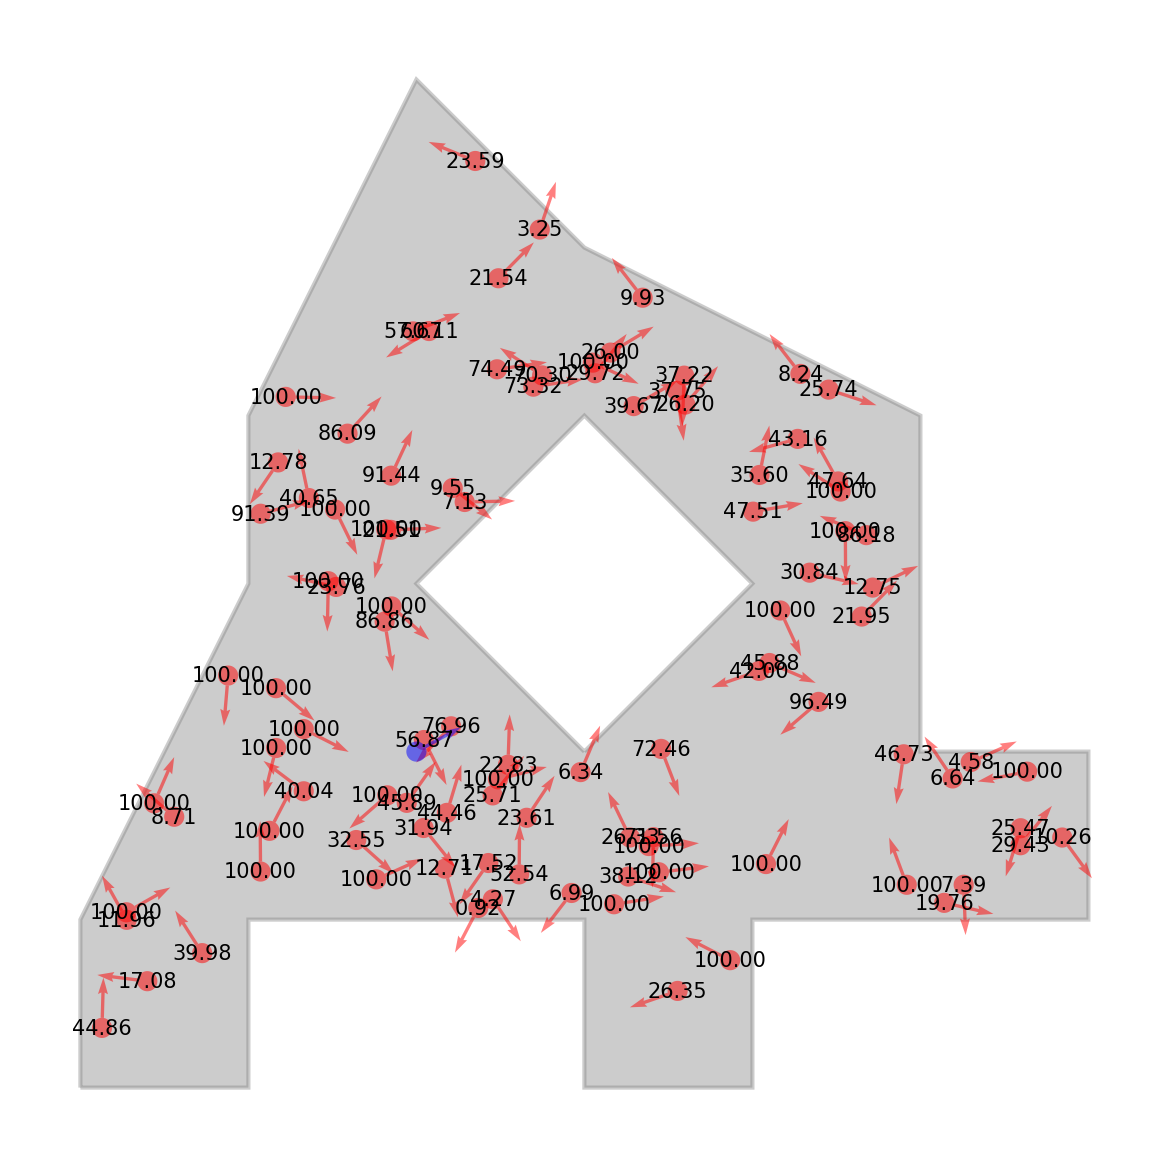

In [8]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")


map.visualize(ax=ax)

for particle in sample_particles:
    particle.visualize(ax=ax, alpha=0.5, color="red")
real_robot.visualize(ax=ax, alpha=0.5, color="blue")

dis = []
for i, particle in enumerate(sample_particles):
    distance = distances[i]
    ax.text(
        particle.center_pos[0],
        particle.center_pos[1],
        f"{distance:.2f}",
        fontsize=5,
        ha="center",
        va="center",
        color="black",
    )

In [ ]:
sample_particles = []
num_particles = 100
for x, y in map.sample_points(n=num_particles, robot_radius=3):
    theta = np.random.uniform(0, 2 * np.pi)
    particle = SampleParticle(x=x, y=y, theta=theta, radius=3, weight=0.1)
    sample_particles.append(particle)

real_robot = Robot(x=100, y=100, theta=0.5, radius=3)

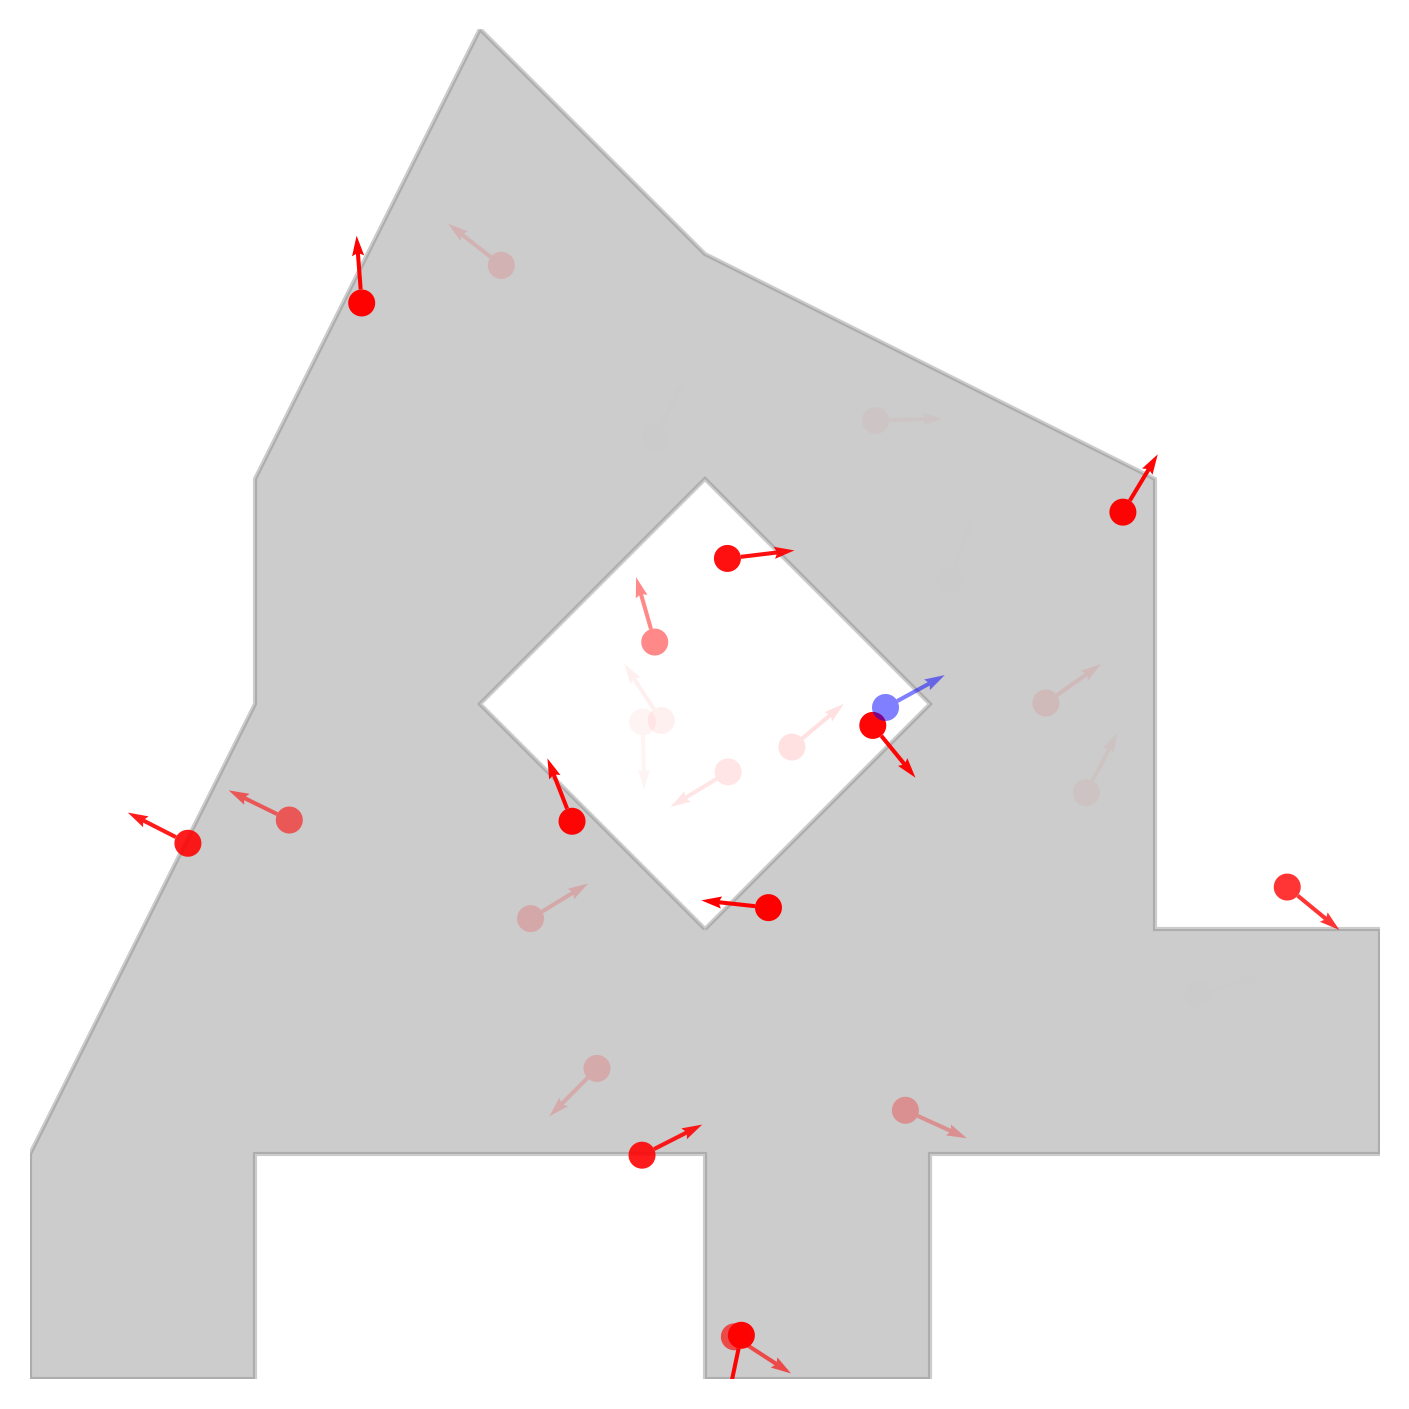

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
fig.tight_layout()

# init
map.visualize(ax)  # background map

robot_plots = []
all_artists = []

# sample particles
for particle in sample_particles:
    plot = particle.visualize(ax, color="red")
    robot_plots.append(plot)
    all_artists.extend(plot)

# real robot
real_robot_plot = real_robot.visualize(ax, alpha=0.5, color="blue")
robot_plots.append(real_robot_plot)
all_artists.extend(real_robot_plot)


def update(frame):
    global all_artists

    # TODO: control node to publish move command
    distance = np.random.uniform(0, 1)
    real_robot.move(distance)
    real_distance = real_robot.measure_distance(map.world, max_distance=100)

    distances = []
    for robot in sample_particles:
        robot.move(distance)
        d = robot.measure_distance(map.world, max_distance=100)
        distances.append(d)

    # TODO: update the weights of the particles
    # distances: use to update the weights of the particles\
    error = np.array(distances) - real_distance
    new_factor = np.exp(-abs(error**2 / (2 * 100)))
    for i, robot in enumerate(sample_particles):
        robot.update_factor(new_factor[i])

    # TODO: resample the particles

    # update particle and robot positions
    for i, robot in enumerate(sample_particles):
        robot.update_artist(robot_plots[i])

    real_robot.update_artist(robot_plots[-1])

    return all_artists


ani = animation.FuncAnimation(
    fig,
    update,
    frames=200,
    interval=50,
    blit=True,
)

ani.save("robo_anim_tt.gif", writer=animation.PillowWriter(fps=30))

In [ ]:
class MCL:
    def __init__(
        self,
        num_particles: int,
        map: Map,
        robot_radius: int | float,
        init_x: int | float,
        init_y: int | float,
        init_theta: int | float,
        max_distance: int | float = 100,
    ) -> None:
        self.num_particles = num_particles
        self.map = map
        # self.particles = []
        # TODO: Can be optimized
        # save all samples position, theta, and weights as np.array
        # only build the particles when needed
        # eg. visualization, solve distance...
        self.particles = ParticleGroup(
            positions=np.array(self.map.sample_points(num_particles, robot_radius)),
            thetas=np.random.uniform(0, 2 * np.pi, num_particles),
            weights=np.ones(num_particles),
        )

        # set up particles
        # for x, y in self.map.sample_points(  # TODO: Can be optimized
        #     self.num_particles, robot_radius=robot_radius
        # ):
        #     theta = np.random.uniform(0, 2 * np.pi)
        #     particle = SampleParticle(
        #         x=x, y=y, theta=theta, radius=robot_radius, max_distance=max_distance
        #     )
        #     self.particles.append(particle)

        # set up real robot
        if self.map.world.contains(Point(init_x, init_y).buffer(robot_radius)):
            self.real_robot = Robot(
                x=init_x,
                y=init_y,
                theta=init_theta,
                radius=robot_radius,
                max_distance=max_distance,
            )
        else:
            raise ValueError(
                "The initial position of the robot is outside the map boundary."
            )

    def updat_weights(
        self, real_distance: np.ndarray, distances: np.ndarray, sigma: int | float = 10
    ) -> np.ndarray:
        # real_distance = self.real_robot.measure_distance(self.map.world)
        # distances = self.particles.measure_distance(self.map.world)

        error = np.array(distances) - real_distance
        new_weights = np.exp(-abs(error**2 / (2 * sigma**2)))

        return new_weights

    def resample(self, map: Map, weights: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Resample the particles by Low Variance Resampling + Random Resampling.

        The algorithm works as follows:
            Low Variance Resampling (LVR, 90% probability):
                1. Normalize the weights so that they sum to 1.
                2. Compute the CDF of the weights.
                3. Sample i/N + s for i in range(N), where s = Uniform(0, 1/N).
                4. Use the CDF to find the indices of the particles to resample.
            Random Resampling (10% probability):
                Resample the particles uniformly in the map.
        
        Args:
            map (Map): The map object, used to sample random positions.
            weights (np.ndarray): The weights of the particles.

        Returns:
            selected_idx (np.ndarray): The indices of the particles selected by LVR.
            random_positions (np.ndarray): The positions of the random sample particles.
            random_thetas (np.ndarray): The thetas of the random sample particles.
        """
        # Random Resampling (10% probability)
        random_mask = np.random.uniform(0, 1, self.num_particles) < 0.1
        # random_positions = self.map.sample_points(
        #     n=np.sum(random_mask), robot_radius=self.real_robot.radius
        # )
        random_positions = map.sample_points(
            n=np.sum(random_mask), robot_radius=self.real_robot.radius
        )
        random_thetas = np.random.uniform(0, 2 * np.pi, np.sum(random_mask))

        # Low Variance Resampling (90% probability)
        # normalize weights
        # normalized_weights = self.particles.weights / np.sum(self.particles.weights)
        normalized_weights = weights / np.sum(weights)
        cdf = np.cumsum(normalized_weights)

        # resample particles
        start_point = np.random.uniform(0, 1 / self.num_particles, 1)
        selected_points = (
            np.arange(self.num_particles) / self.num_particles + start_point
        )

        selected_idx = np.searchsorted(cdf, selected_points, side="right")
        selected_idx = selected_idx[~random_mask]

        return selected_idx, random_positions, random_thetas

In [13]:
weight = np.array([0.1, 0.2, 0.3, 0.4])
n_weights = weight / np.sum(weight)
cdf = np.cumsum(n_weights)
v = np.random.uniform(0, 1 / len(weight), 1)
selected = np.arange(len(weight)) / len(weight) + v
index_mask = np.searchsorted(cdf, selected)
print(index_mask)

[0 2 2 3]


In [16]:
a = np.array([1, 2, 3, 4])
b = np.array([100, 200, 300, 400])

mask = a < 3
print(b[~mask])

[300 400]
